# **Installations and imports**

In [2]:
pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [3]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 46.6 MB/s eta 0:00:00


In [4]:
!pip install dgllife

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.7 MB/s eta 0:00:00


In [5]:
!pip install mmpdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 kB 5.4 MB/s eta 0:00:00


In [20]:
import deepchem as dc
import numpy as np
import pandas as pd
import subprocess
from distutils.spawn import find_executable
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import qed
from rdkit import Chem
from rdkit import DataStructs
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Custom function for idea generation using mmpdb

In [7]:
def generate_ideas(input_smi, prop="pCC50", database="AllHepG2.mmpdb", 
					delta="-1", max_ideas=None, output="out.tmp",
					sorting_weights=(0.7,0.3)):
    if find_executable("mmpdb") is None:
    	raise Exception("mmpdb is not installed")
    subprocess.run(["mmpdb", "transform", "-s", input_smi, 
                    database, "-p", prop, "--where", "avg<"+str(delta), "-o", output])
    ideas_df = pd.read_csv(output,sep="\t")
    PandasTools.AddMoleculeColumnToFrame(ideas_df,'SMILES','Molecule')
    ideas_df['qed'] = ideas_df['Molecule'].apply(qed)
    
    fps = [Chem.RDKFingerprint(mol) for mol in ideas_df['Molecule']]
    q_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(input_smi))
    sims = DataStructs.BulkTanimotoSimilarity(q_fp, fps)
    ideas_df['sims'] = sims
    ideas_df['sort_by'] = sorting_weights[0]*ideas_df['sims']+sorting_weights[1]*ideas_df['qed']
    
    ideas_df.sort_values('sort_by', ascending=False, inplace=True)
    if max_ideas is not None:
    	return ideas_df[0:max_ideas]
    else:
    	return ideas_df

# Load Tox21 data and compute atom counts and qed score per molecule

In [8]:
tox21_df = pd.read_csv('../data/tox21.csv.gz')
PandasTools.AddMoleculeColumnToFrame(tox21_df, 'smiles', 'Molecule')
tox21_df['qed'] = tox21_df['Molecule'].apply(qed)
tox21_df['atom_count'] = tox21_df['Molecule'].apply(Chem.rdMolDescriptors.CalcNumAtoms)
tox21_df.head()

[16:22:29] WARNING: not removing hydrogen atom without neighbors
[16:22:31] WARNING: not removing hydrogen atom without neighbors


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles,Molecule,qed,atom_count
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,<rdkit.Chem.rdchem.Mol object at 0x7f277fc12270>,0.900283,26
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7f277fc12350>,0.738013,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x7f277fc123c0>,0.666269,53
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,<rdkit.Chem.rdchem.Mol object at 0x7f277fc12430>,0.822261,48
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7f277fc124a0>,0.365583,19


# **Load Tox21 via DeepChem API with appropriate featurizer and splitter**

In [9]:
tox21_tasks4b, tox21_datasets4b, transformers4b = dc.molnet.load_tox21(featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True))
train_dataset4b, valid_dataset4b, test_dataset4b = tox21_datasets4b

[16:22:58] WARNING: not removing hydrogen atom without neighbors
/usr/local/lib/python3.9/dist-packages/deepchem/feat/base_classes.py:323: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)
[16:24:09] WARNING: not removing hydrogen atom without neighbors


# **Load pre-trained Attentive FP model**

In [10]:
afp_reload=dc.models.AttentiveFPModel(n_tasks=12, batch_size=50, mode='classification', learning_rate=0.001, random_state=2, model_dir='AFPmodels')
afp_reload.restore()

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# **Confirm pre-trained model behaves as expected**

In [11]:
metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification"),dc.metrics.Metric(dc.metrics.balanced_accuracy_score, np.mean, mode="classification")]
afp_train_scores = afp_reload.evaluate(train_dataset4b, metrics, transformers4b)
afp_test_scores = afp_reload.evaluate(test_dataset4b, metrics, transformers4b)
print('Train scores: ', afp_train_scores)
print('Test scores: ', afp_test_scores)

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Train scores:  {'mean-roc_auc_score': 0.9494640406963315, 'mean-balanced_accuracy_score': 0.8890099034450766}
Test scores:  {'mean-roc_auc_score': 0.7111218616110121, 'mean-balanced_accuracy_score': 0.6587147134430827}


# **Sample 1000 molecules from Tox21 to use as inputs for idea generation**

In [37]:
tox21_sample = tox21_df.sample(1000)

# **Generate ideas based on 1000 sample molecules and tabulate various metrics if not already available (takes ~1 hr to run)**

In [71]:
if os.path.exists('../data/AFP_IdeaGenStats.csv') and os.path.exists('../data/IdeaGenSuccessRate.csv'):
  ideaGenReload = pd.read_csv("../data/AFP_IdeaGenStats.csv")
  success_rate_df = pd.read_csv("../data/IdeaGenSuccessRate.csv")
else:
  featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
  improvement_counts = []
  idea_counts = []
  input_qed_scores = []
  avg_delta_qed = []
  std_delta_qed = []
  max_delta_qed = []
  max_qed = []
  avg_qed = []
  std_qed = []
  failed_count = 0
  nontox_count = 0

  for idx, input in tox21_sample.iterrows():
    if (input['atom_count'] > 1) and ("." not in input['smiles']):
      try:
        s_featurized = featurizer.featurize(input['smiles'])
        preds = afp_reload.predict_on_batch(s_featurized, transformers4b)
        preds_df = pd.DataFrame(preds[0], columns=['Prob False','Prob Tox'])
        preds_df['Assay'] = tox21_tasks4b
        input_tox_count = np.sum(preds_df['Prob Tox'] > 0.6)
      except:
        failed_count+=1
        pass

    ideas_df = generate_ideas(input['smiles'], database="AllHepG2.mmpdb")
    num_ideas = len(ideas_df)
    if input_tox_count == 0:
      nontox_count += 1
    elif num_ideas > 0:
      try:
        ideas_df.reset_index(inplace=True)
        featurized_ideas = featurizer.featurize(ideas_df['SMILES'])
        idea_preds = afp_reload.predict_on_batch(featurized_ideas, transformers=transformers4b)
        toxicity_counts = [np.sum(pred>0.6) for pred in idea_preds[:,:,1]]
        ideas_df['toxicity_counts'] = toxicity_counts
        ideas_df['delta_qed'] = ideas_df['qed'] - input['qed']

        input_qed_scores.append(input['qed'])
        idea_counts.append(num_ideas)
        avg_qed.append(np.median(ideas_df['qed']))
        max_qed.append(np.max(ideas_df['qed']))
        std_qed.append(np.std(ideas_df['qed']))
        avg_delta_qed.append(np.median(ideas_df['delta_qed']))
        max_delta_qed.append(np.max(ideas_df['delta_qed']))
        std_delta_qed.append(np.std(ideas_df['delta_qed']))
        improvement_counts.append((ideas_df['toxicity_counts'] < input_tox_count).sum())
      except:
        failed_count += 1
        pass
    else:
      failed_count += 1
  ideaGenStats = pd.DataFrame(list(zip(input_qed_scores, idea_counts,avg_qed,max_qed,std_qed,avg_delta_qed,max_delta_qed,std_delta_qed,improvement_counts)),
             columns=['input_qed','idea_count','avg_qed','max_qed','std_qed','avg_delta_qed','max_delta_qed','std_delta_qed','imrovement_counts'])
  ideaGenStats.to_csv('../data/AFP_IdeaGenStats.csv')
  ideaGenReload = pd.read_csv("../data/AFP_IdeaGenStats.csv")
  no_improvement_count = (ideaGenReload['imrovement_counts'] < 1).sum()
  improvement_count = (ideaGenReload['imrovement_counts'] >= 1).sum()
  success_rate_df = pd.DataFrame([improvement_count,nontox_count,failed_count,no_improvement_count, ], index=['Improved\n Predicted Tox','Non-toxic input','Failed','No improvement'],columns=['count'])
  success_rate_df.reset_index(inplace=True) 
  success_rate_df.to_csv('../data/IdeaGenSuccessRate.csv')

# **Create a Pandas dataframe with the idea generation metrics and save it**

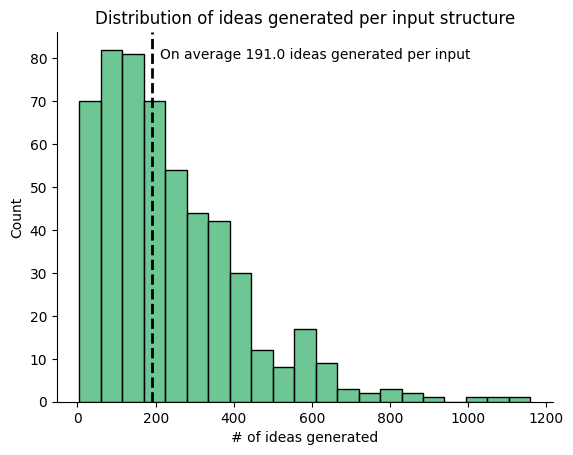

In [72]:
ax = sns.histplot(data=ideaGenReload, x='idea_count', color='mediumseagreen')
ax.set(xlabel='# of ideas generated', title='Distribution of ideas generated per input structure')
plt.axvline(ideaGenReload['idea_count'].median(), c='k', ls='--', lw=2)
ax.text(210,80,'On average ' + str(ideaGenReload['idea_count'].median()) + ' ideas generated per input')
sns.despine()

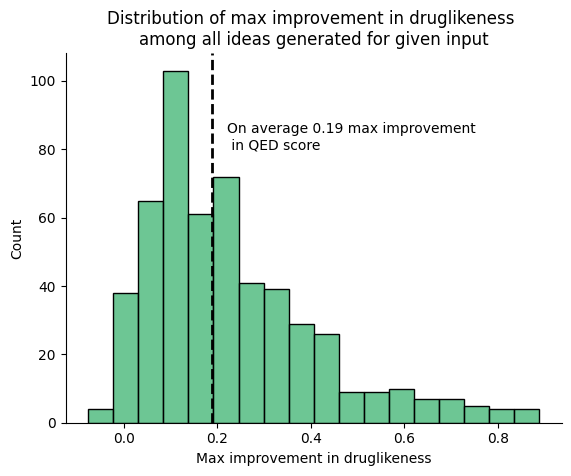

In [73]:
ax = sns.histplot(data=ideaGenReload, x='max_delta_qed', color='mediumseagreen')
ax.set(xlabel='Max improvement in druglikeness', title='Distribution of max improvement in druglikeness \namong all ideas generated for given input')
plt.axvline(ideaGenReload['max_delta_qed'].median(), c='k', ls='--', lw=2)
median_max_improvement = ideaGenReload['max_delta_qed'].median()
ax.text(0.22,80,'On average ' + f'{median_max_improvement:2.2f}' + ' max improvement\n in QED score')
sns.despine()

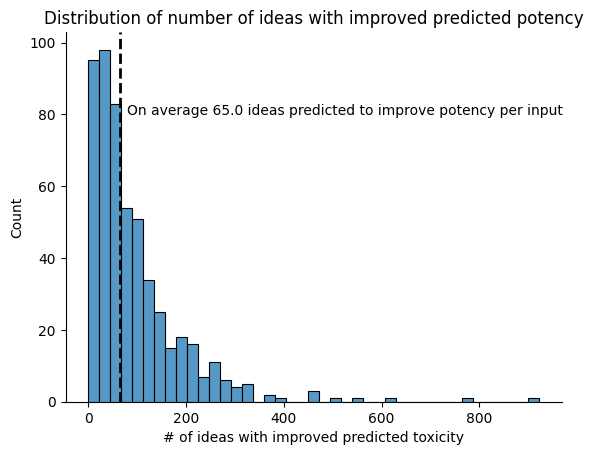

In [78]:
ax = sns.histplot(data=ideaGenReload, x='imrovement_counts')
ax.set(xlabel='# of ideas with improved predicted toxicity', title='Distribution of number of ideas with improved predicted potency')
median_improvecount = ideaGenReload['imrovement_counts'].median()
plt.axvline(median_improvecount, c='k', ls='--', lw=2)
ax.text(median_improvecount+15,80,'On average ' + str(median_improvecount) + ' ideas predicted to improve potency per input')
sns.despine()

In [75]:
success_rate_df['frac'] = success_rate_df['count']/success_rate_df['count'].sum()

In [76]:
def percent_str(x):
  return '{0:.1%}'.format(x)

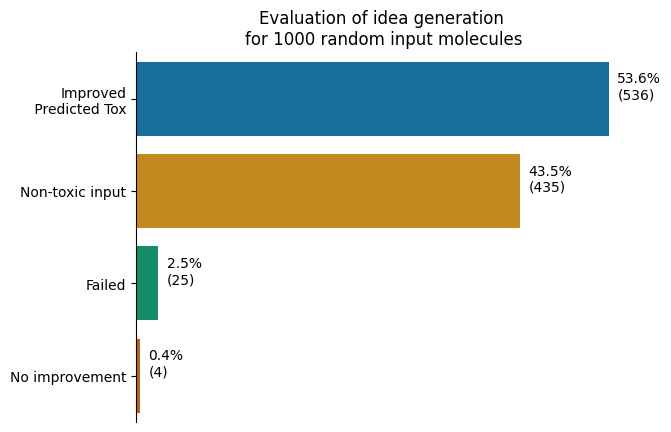

In [77]:
ax = sns.barplot(data=success_rate_df, x='count',y='index', palette=sns.color_palette('colorblind'))
ax.set(title='Evaluation of idea generation \nfor 1000 random input molecules')
ax.text(success_rate_df.iloc[0,2] + 10, 0, percent_str(success_rate_df.iloc[0,3])+'\n('+str(success_rate_df.iloc[0,2])+')')
ax.text(success_rate_df.iloc[1,2] + 10, 1, percent_str(success_rate_df.iloc[1,3])+'\n('+str(success_rate_df.iloc[1,2])+')')
ax.text(success_rate_df.iloc[2,2] + 10, 2, percent_str(success_rate_df.iloc[2,3])+'\n('+str(success_rate_df.iloc[2,2])+')')
ax.text(success_rate_df.iloc[3,2] + 10, 3, percent_str(success_rate_df.iloc[3,3])+'\n('+str(success_rate_df.iloc[3,2])+')')
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.xticks([])
sns.despine(bottom=True)